# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 1 in Shi Jin's paper (2008-jy-phase.pdf):
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = e^{-25x^2}, \ S_0(x) = -0.2\log(2\cosh(5x)).
$$

Periodic BC.

Domain: $[-0.25, 0.25]\times [0, 0.5]$.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25x^2}\cos(-0.2\log(2\cosh(5x))/\varepsilon), \ q(x, 0) = e^{-25x^2}\sin(-0.2\log(2\cosh(5x))/\varepsilon),
$$
and bc
$$
p(x_0, t) = p(x_1, t), q(x_0, t) = q(x_1, t), p_x(x_0, t) = p_x(x_1, t), q_x(x_0, t) = q_x(x_1, t).
$$

In [1]:
NAME = "1_3"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [3] + [32]*2 + [2] # (x, t) -> (u, v)
# layers = [2] + [32]*2 + [2]
c0 = 6.0
w0 = jnp.array([[10.0, 10.0, 1.0]]).T # (w_x, w_t)
# w0 = jnp.array([[30.0, 30.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)
# direct_params = init_tanh_params(subkey, layers)

domain = jnp.array([[-0.25, 0.], [0.25, 0.5]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 1.0
V = 10.0

@jax.jit
def model(params, xt): # for predictions
	# first, normalize to [-1, 1] <- enforce periodic bc
# 	xt = jnp.sin(2.0*jnp.pi*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - jnp.pi)
	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
	xt = index_update(xt, index[:,0], jnp.sin(2*jnp.pi*xt[:,0]/spatial_width))
	xt = index_update(xt, index[:,1], jnp.cos(2*jnp.pi*xt[:,1]/spatial_width))
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

@jax.jit
def model_(params, xt): # for derivatives
	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
	xt = index_update(xt, index[0], jnp.sin(2*jnp.pi*xt[0]/spatial_width))
	xt = index_update(xt, index[1], jnp.cos(2*jnp.pi*xt[1]/spatial_width))
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

# @jax.jit
# def model(params, xt): # for predictions
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model_)
hessian = hessian_fn(model_)

In [4]:
metaloss = mae

jit_conservation = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, neumann = batch["collocation"], batch["dirichlet"], batch["neumann"]
	direct_params = params
	
# 	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
# 	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
# 	# jacobian[i] = [[du/dx, du/dt],
# 	#                [dv/dx, dv/dt]]
# 	# i: the i^th input
# 	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
# 	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
# 	# hessian[i] = [
#     #				[[du/dxx, du/dxy],
# 	#                [du/dxy, du/dyy]],
# 	#               [[dv/dxx, dv/dxy],
# 	#                [dv/dxy, dv/dyy]]
# 	#              ]
# 	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
# 	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
	duv_dxt_n = jacobian(direct_params, jnp.hstack([neumann.x, neumann.t]))
	du_dt_n, dv_dt_n = duv_dxt_n[:, 0:1, 1], duv_dxt_n[:, 1:2, 1]
	du_dx_n, dv_dx_n = duv_dxt_n[:, 0:1, 0], duv_dxt_n[:, 1:2, 0]
	
	duv_dxxtt_n = hessian(direct_params, jnp.hstack([neumann.x, neumann.t]))
	du_dxx_n, dv_dxx_n = duv_dxxtt_n[:, 0:1, 0, 0], duv_dxxtt_n[:, 1:2, 0, 0]
	
# 	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
# 	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
# 	loss_c = loss_c1 + loss_c2
	loss_c = 0.0
	
	loss_d1 = metaloss(u_d, dirichlet.u)
	loss_d2 = metaloss(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	loss_n_t1 = metaloss(du_dt_n, neumann.du_dt)
	loss_n_t2 = metaloss(dv_dt_n, neumann.dv_dt)
	loss_n_x1 = metaloss(du_dx_n, neumann.du_dx)
	loss_n_x2 = metaloss(dv_dx_n, neumann.dv_dx)
	loss_n_xx1 = metaloss(du_dxx_n, neumann.du_dxx)
	loss_n_xx2 = metaloss(dv_dxx_n, neumann.dv_dxx)
	loss_nt = loss_n_t1 + loss_n_t2
	loss_nx = loss_n_x1 + loss_n_x2
	loss_nxx = loss_n_xx1 + loss_n_xx2
	
	return loss_c, loss_d, loss_nt, loss_nx, loss_nxx


@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_nt, loss_nx, loss_nxx = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["nt"]*loss_nt + w["nx"]*loss_nx + w["nxx"]*loss_nxx + l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_nt, loss_nx, loss_nxx = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c"]*loss_c + w["d"]*loss_d + w["nt"]*loss_nt + w["nx"]*loss_nx + w["nxx"]*loss_nxx, loss_c, loss_d, loss_nt, loss_nx, loss_nxx, l1, l2

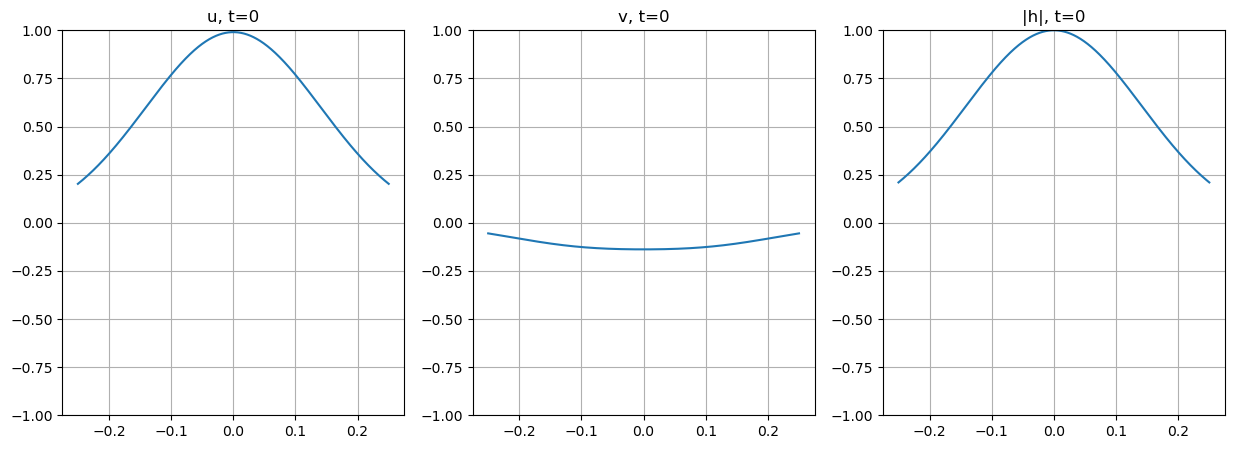

In [5]:
u0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))
v0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))

u0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))
v0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

du0_dxx_fn = lambda xt: jax.vmap(jax.hessian(u0_fn_), in_axes = 0)(xt)[:, 0, 0:1]
dv0_dxx_fn = lambda xt: jax.vmap(jax.hessian(v0_fn_), in_axes = 0)(xt)[:, 0, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 1000
# x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
# x_i_l = jnp.linspace(domain[0, 0], domain[0, 0]+0.05, 100).reshape((-1, 1))
# x_i_r = jnp.linspace(domain[1, 0]-0.05, domain[1, 0], 100).reshape((-1, 1))
# x_i = jnp.vstack([x_i, x_i_l, x_i_r])
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)
du_dxx_i = du0_dxx_fn(jnp.hstack([x_i, t_i]))
dv_dxx_i = dv0_dxx_fn(jnp.hstack([x_i, t_i]))
du_dt_i = 1.0/epsilon*(V*v_i - 1/2*epsilon**2*dv_dxx_i)
dv_dt_i = 1.0/epsilon*(1/2*epsilon**2*du_dxx_i - V*u_i)
du_dx_i = du0_dx_fn(jnp.hstack([x_i, t_i]))
dv_dx_i = dv0_dx_fn(jnp.hstack([x_i, t_i]))

n_cx = 100
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_Neumann = namedtuple("dataset_Neumann", ["x", "t", "du_dt", "dv_dt", "du_dx", "dv_dx", "du_dxx", "dv_dxx"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x]),
								 jnp.vstack([dirichlet.t]))
neumann = dataset_Neumann(x_i, t_i, du_dt_i, dv_dt_i, du_dx_i, dv_dx_i, du_dxx_i, dv_dxx_i)

class Time_Marching_Generator:
	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every):
		self.key = key
		self.spatial_points = spatial_points
		self.domain = temporal_domain
		self.batch_size = batch_size
		self.iterations = iterations
		self._count1 = 0
		self._count2 = update_every
		self.update_every = update_every
		
	def _update(self, key, tmax):
		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self._count2 == self.update_every:
			self._count1 = max(self.iterations, self._count1 + 1)
			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
			self.key, subkey = random.split(self.key)
			self._update(subkey, tmax)
			self._count2 = 0
		else:
			self._count2 += 1
		return self.spatial_points, self._t

In [6]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 100000
print_every = 500
save_every = 10000
batch_size = {"dirichlet": 100, "collocation": 1, "neumann": 100}
weights = {"c": 0, "d": 1.0, "nt": 1.0, "nx": 1.0, "nxx": 1e-1, "l1": 0, "l2": 0}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Neumann = Batch_Generator(subkeys[1], neumann, batch_size["neumann"])
Collocation = Time_Marching_Generator(subkeys[3], x_c, [0.0, 0.0], n_cx, iterations, 1)

params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(*d[:2]),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/16, 01:21:27, Iteration: 0, Train Loss: 3.3007e+03, c: 0.0000e+00, d: 1.6857e+00, nt: 1.8174e+01, nx: 1.4599e+02, nxx: 3.1348e+04, l1_reg: 7.0034e+02, l2_reg: 4.2622e+03
2020/08/16, 01:21:33, Iteration: 500, Train Loss: 4.6870e+01, c: 0.0000e+00, d: 4.8614e-01, nt: 1.5844e+01, nx: 5.3828e+00, nxx: 2.5157e+02, l1_reg: 6.9823e+02, l2_reg: 4.2456e+03
2020/08/16, 01:21:40, Iteration: 1000, Train Loss: 4.2126e+01, c: 0.0000e+00, d: 2.7868e-01, nt: 1.6772e+01, nx: 3.8042e+00, nxx: 2.1271e+02, l1_reg: 7.0199e+02, l2_reg: 4.2544e+03
2020/08/16, 01:21:47, Iteration: 1500, Train Loss: 4.1315e+01, c: 0.0000e+00, d: 1.7470e-01, nt: 1.6614e+01, nx: 2.7277e+00, nxx: 2.1799e+02, l1_reg: 7.0607e+02, l2_reg: 4.2682e+03
2020/08/16, 01:21:54, Iteration: 2000, Train Loss: 3.8445e+01, c: 0.0000e+00, d: 1.2503e-01, nt: 1.6395e+01, nx: 1.9880e+00, nxx: 1.9937e+02, l1_reg: 7.1135e+02, l2_reg: 4.2860e+03
2020/08/16, 01:22:00, Iteration: 2500, Train Loss: 3.1752e+01, c: 0.0000e+00, d: 7.9002e-02, nt: 1.

2020/08/16, 01:26:31, Iteration: 23000, Train Loss: 2.0923e+01, c: 0.0000e+00, d: 2.3753e-02, nt: 1.4450e+01, nx: 6.8196e-01, nxx: 5.7673e+01, l1_reg: 8.1117e+02, l2_reg: 5.4117e+03
2020/08/16, 01:26:37, Iteration: 23500, Train Loss: 2.4951e+01, c: 0.0000e+00, d: 2.5275e-02, nt: 1.6289e+01, nx: 8.0467e-01, nxx: 7.8316e+01, l1_reg: 8.1160e+02, l2_reg: 5.4298e+03
2020/08/16, 01:26:44, Iteration: 24000, Train Loss: 2.3536e+01, c: 0.0000e+00, d: 2.9309e-02, nt: 1.6663e+01, nx: 6.6203e-01, nxx: 6.1816e+01, l1_reg: 8.1211e+02, l2_reg: 5.4492e+03
2020/08/16, 01:26:51, Iteration: 24500, Train Loss: 2.3564e+01, c: 0.0000e+00, d: 1.9913e-02, nt: 1.5512e+01, nx: 8.8408e-01, nxx: 7.1474e+01, l1_reg: 8.1257e+02, l2_reg: 5.4686e+03
2020/08/16, 01:26:57, Iteration: 25000, Train Loss: 2.1897e+01, c: 0.0000e+00, d: 2.7156e-02, nt: 1.4701e+01, nx: 8.4373e-01, nxx: 6.3245e+01, l1_reg: 8.1305e+02, l2_reg: 5.4892e+03
2020/08/16, 01:27:04, Iteration: 25500, Train Loss: 2.2075e+01, c: 0.0000e+00, d: 2.1699e-

2020/08/16, 01:31:35, Iteration: 46000, Train Loss: 7.9674e+00, c: 0.0000e+00, d: 2.0618e-02, nt: 2.5320e+00, nx: 6.6630e-01, nxx: 4.7484e+01, l1_reg: 8.8346e+02, l2_reg: 7.5516e+03
2020/08/16, 01:31:42, Iteration: 46500, Train Loss: 6.8607e+00, c: 0.0000e+00, d: 2.3908e-02, nt: 2.4460e+00, nx: 6.6346e-01, nxx: 3.7273e+01, l1_reg: 8.8133e+02, l2_reg: 7.5235e+03
2020/08/16, 01:31:48, Iteration: 47000, Train Loss: 6.2708e+00, c: 0.0000e+00, d: 2.0216e-02, nt: 2.2295e+00, nx: 6.1605e-01, nxx: 3.4050e+01, l1_reg: 8.7796e+02, l2_reg: 7.5051e+03
2020/08/16, 01:31:55, Iteration: 47500, Train Loss: 5.6136e+00, c: 0.0000e+00, d: 1.7310e-02, nt: 1.5710e+00, nx: 6.8776e-01, nxx: 3.3376e+01, l1_reg: 8.7680e+02, l2_reg: 7.4969e+03
2020/08/16, 01:32:01, Iteration: 48000, Train Loss: 5.1188e+00, c: 0.0000e+00, d: 1.8854e-02, nt: 1.2029e+00, nx: 5.8266e-01, nxx: 3.3144e+01, l1_reg: 8.7635e+02, l2_reg: 7.4923e+03
2020/08/16, 01:32:08, Iteration: 48500, Train Loss: 5.5563e+00, c: 0.0000e+00, d: 1.7037e-

2020/08/16, 01:36:43, Iteration: 69000, Train Loss: 3.7790e+00, c: 0.0000e+00, d: 1.0316e-02, nt: 6.6935e-02, nx: 3.9556e-01, nxx: 3.3062e+01, l1_reg: 9.1500e+02, l2_reg: 8.4328e+03
2020/08/16, 01:36:49, Iteration: 69500, Train Loss: 3.2102e+00, c: 0.0000e+00, d: 1.3182e-02, nt: 7.0428e-02, nx: 4.0462e-01, nxx: 2.7220e+01, l1_reg: 9.1557e+02, l2_reg: 8.4477e+03
2020/08/16, 01:36:56, Iteration: 70000, Train Loss: 2.9441e+00, c: 0.0000e+00, d: 8.5712e-03, nt: 6.4241e-02, nx: 4.0785e-01, nxx: 2.4635e+01, l1_reg: 9.1610e+02, l2_reg: 8.4621e+03
2020/08/16, 01:37:02, Iteration: 70500, Train Loss: 2.6520e+00, c: 0.0000e+00, d: 1.0196e-02, nt: 5.9316e-02, nx: 3.7560e-01, nxx: 2.2069e+01, l1_reg: 9.1657e+02, l2_reg: 8.4768e+03
2020/08/16, 01:37:09, Iteration: 71000, Train Loss: 3.1982e+00, c: 0.0000e+00, d: 9.9387e-03, nt: 5.4977e-02, nx: 3.7004e-01, nxx: 2.7633e+01, l1_reg: 9.1707e+02, l2_reg: 8.4916e+03
2020/08/16, 01:37:15, Iteration: 71500, Train Loss: 3.2776e+00, c: 0.0000e+00, d: 1.4053e-

2020/08/16, 01:41:46, Iteration: 92000, Train Loss: 2.7113e+00, c: 0.0000e+00, d: 7.1436e-03, nt: 6.0904e-02, nx: 3.5238e-01, nxx: 2.2909e+01, l1_reg: 9.3584e+02, l2_reg: 8.9090e+03
2020/08/16, 01:41:53, Iteration: 92500, Train Loss: 2.0873e+00, c: 0.0000e+00, d: 8.2872e-03, nt: 5.8555e-02, nx: 2.6635e-01, nxx: 1.7541e+01, l1_reg: 9.3617e+02, l2_reg: 8.9162e+03
2020/08/16, 01:41:59, Iteration: 93000, Train Loss: 2.1431e+00, c: 0.0000e+00, d: 8.9302e-03, nt: 6.8675e-02, nx: 2.3081e-01, nxx: 1.8347e+01, l1_reg: 9.3649e+02, l2_reg: 8.9225e+03
2020/08/16, 01:42:06, Iteration: 93500, Train Loss: 2.7887e+00, c: 0.0000e+00, d: 8.8452e-03, nt: 4.5132e-02, nx: 3.5271e-01, nxx: 2.3820e+01, l1_reg: 9.3670e+02, l2_reg: 8.9285e+03
2020/08/16, 01:42:13, Iteration: 94000, Train Loss: 1.8891e+00, c: 0.0000e+00, d: 1.1871e-02, nt: 7.0844e-02, nx: 2.3616e-01, nxx: 1.5702e+01, l1_reg: 9.3679e+02, l2_reg: 8.9331e+03
2020/08/16, 01:42:20, Iteration: 94500, Train Loss: 2.7822e+00, c: 0.0000e+00, d: 1.1522e-

In [8]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 1000000
print_every = 500
save_every = 10000
batch_size = {"dirichlet": 100, "collocation": 1, "neumann": 100}
weights = {"c": 0, "d": 1.0, "nt": 1.0, "nx": 1.0, "nxx": 1e-1, "l1": 0, "l2": 0}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(*d[:2]),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/16, 01:44:24, Iteration: 0, Train Loss: 2.5008e+00, c: 0.0000e+00, d: 8.7929e-03, nt: 4.7661e-02, nx: 3.0145e-01, nxx: 2.1429e+01, l1_reg: 9.3833e+02, l2_reg: 8.9967e+03
2020/08/16, 01:44:31, Iteration: 500, Train Loss: 1.3882e+00, c: 0.0000e+00, d: 4.2400e-03, nt: 4.2368e-02, nx: 1.4856e-01, nxx: 1.1930e+01, l1_reg: 9.3835e+02, l2_reg: 8.9961e+03
2020/08/16, 01:44:37, Iteration: 1000, Train Loss: 2.0928e+00, c: 0.0000e+00, d: 7.2541e-03, nt: 5.2242e-02, nx: 2.4332e-01, nxx: 1.7900e+01, l1_reg: 9.3842e+02, l2_reg: 8.9993e+03
2020/08/16, 01:44:44, Iteration: 1500, Train Loss: 2.2590e+00, c: 0.0000e+00, d: 5.6061e-03, nt: 3.5341e-02, nx: 2.3034e-01, nxx: 1.9877e+01, l1_reg: 9.3827e+02, l2_reg: 9.0032e+03
2020/08/16, 01:44:51, Iteration: 2000, Train Loss: 1.9459e+00, c: 0.0000e+00, d: 5.6030e-03, nt: 4.8547e-02, nx: 2.4372e-01, nxx: 1.6481e+01, l1_reg: 9.3829e+02, l2_reg: 9.0081e+03
2020/08/16, 01:44:57, Iteration: 2500, Train Loss: 2.7657e+00, c: 0.0000e+00, d: 8.0368e-03, nt: 5.

2020/08/16, 01:49:28, Iteration: 23000, Train Loss: 1.7205e+00, c: 0.0000e+00, d: 7.3747e-03, nt: 6.9507e-02, nx: 2.0402e-01, nxx: 1.4396e+01, l1_reg: 9.3899e+02, l2_reg: 9.1673e+03
2020/08/16, 01:49:35, Iteration: 23500, Train Loss: 2.7811e+00, c: 0.0000e+00, d: 9.0352e-03, nt: 5.5929e-02, nx: 2.9131e-01, nxx: 2.4248e+01, l1_reg: 9.3894e+02, l2_reg: 9.1694e+03
2020/08/16, 01:49:41, Iteration: 24000, Train Loss: 2.4934e+00, c: 0.0000e+00, d: 9.3967e-03, nt: 5.4972e-02, nx: 3.0551e-01, nxx: 2.1235e+01, l1_reg: 9.3890e+02, l2_reg: 9.1742e+03
2020/08/16, 01:49:48, Iteration: 24500, Train Loss: 2.4284e+00, c: 0.0000e+00, d: 6.3459e-03, nt: 4.7206e-02, nx: 2.4426e-01, nxx: 2.1306e+01, l1_reg: 9.3881e+02, l2_reg: 9.1776e+03
2020/08/16, 01:49:54, Iteration: 25000, Train Loss: 2.9270e+00, c: 0.0000e+00, d: 6.9039e-03, nt: 4.0775e-02, nx: 2.9892e-01, nxx: 2.5804e+01, l1_reg: 9.3870e+02, l2_reg: 9.1813e+03
2020/08/16, 01:50:01, Iteration: 25500, Train Loss: 1.7396e+00, c: 0.0000e+00, d: 1.1889e-

2020/08/16, 01:54:32, Iteration: 46000, Train Loss: 1.8440e+00, c: 0.0000e+00, d: 5.3390e-03, nt: 5.3297e-02, nx: 1.7946e-01, nxx: 1.6059e+01, l1_reg: 9.3127e+02, l2_reg: 9.3485e+03
2020/08/16, 01:54:39, Iteration: 46500, Train Loss: 2.3745e+00, c: 0.0000e+00, d: 6.4930e-03, nt: 5.3438e-02, nx: 2.4477e-01, nxx: 2.0698e+01, l1_reg: 9.3127e+02, l2_reg: 9.3535e+03
2020/08/16, 01:54:46, Iteration: 47000, Train Loss: 2.2669e+00, c: 0.0000e+00, d: 9.2415e-03, nt: 7.2105e-02, nx: 2.4034e-01, nxx: 1.9452e+01, l1_reg: 9.3112e+02, l2_reg: 9.3571e+03
2020/08/16, 01:54:53, Iteration: 47500, Train Loss: 1.8474e+00, c: 0.0000e+00, d: 5.7115e-03, nt: 4.9235e-02, nx: 2.0058e-01, nxx: 1.5918e+01, l1_reg: 9.3090e+02, l2_reg: 9.3602e+03
2020/08/16, 01:54:59, Iteration: 48000, Train Loss: 2.2691e+00, c: 0.0000e+00, d: 4.9094e-03, nt: 4.8365e-02, nx: 2.3086e-01, nxx: 1.9850e+01, l1_reg: 9.3090e+02, l2_reg: 9.3635e+03
2020/08/16, 01:55:06, Iteration: 48500, Train Loss: 2.0216e+00, c: 0.0000e+00, d: 8.7251e-

2020/08/16, 02:01:22, Iteration: 77000, Train Loss: 2.9185e+00, c: 0.0000e+00, d: 5.2948e-03, nt: 6.0606e-02, nx: 2.7654e-01, nxx: 2.5761e+01, l1_reg: 9.2406e+02, l2_reg: 9.5692e+03
2020/08/16, 02:01:29, Iteration: 77500, Train Loss: 2.2723e+00, c: 0.0000e+00, d: 6.5978e-03, nt: 4.8532e-02, nx: 2.4312e-01, nxx: 1.9740e+01, l1_reg: 9.2414e+02, l2_reg: 9.5733e+03
2020/08/16, 02:01:36, Iteration: 78000, Train Loss: 1.6027e+00, c: 0.0000e+00, d: 8.3208e-03, nt: 4.5566e-02, nx: 1.9810e-01, nxx: 1.3507e+01, l1_reg: 9.2406e+02, l2_reg: 9.5776e+03
2020/08/16, 02:01:42, Iteration: 78500, Train Loss: 1.2521e+00, c: 0.0000e+00, d: 6.1306e-03, nt: 6.3663e-02, nx: 1.2969e-01, nxx: 1.0526e+01, l1_reg: 9.2393e+02, l2_reg: 9.5812e+03
2020/08/16, 02:01:49, Iteration: 79000, Train Loss: 1.9296e+00, c: 0.0000e+00, d: 6.2607e-03, nt: 5.4910e-02, nx: 1.7714e-01, nxx: 1.6913e+01, l1_reg: 9.2383e+02, l2_reg: 9.5836e+03
2020/08/16, 02:01:55, Iteration: 79500, Train Loss: 1.5384e+00, c: 0.0000e+00, d: 1.1790e-

2020/08/16, 02:06:27, Iteration: 100000, Train Loss: 2.2154e+00, c: 0.0000e+00, d: 5.7258e-03, nt: 3.7472e-02, nx: 2.1629e-01, nxx: 1.9559e+01, l1_reg: 9.2103e+02, l2_reg: 9.7383e+03
2020/08/16, 02:06:33, Iteration: 100500, Train Loss: 1.7042e+00, c: 0.0000e+00, d: 3.1510e-03, nt: 4.7665e-02, nx: 1.6117e-01, nxx: 1.4922e+01, l1_reg: 9.2099e+02, l2_reg: 9.7421e+03
2020/08/16, 02:06:40, Iteration: 101000, Train Loss: 2.5684e+00, c: 0.0000e+00, d: 3.5309e-03, nt: 4.7884e-02, nx: 2.3135e-01, nxx: 2.2856e+01, l1_reg: 9.2095e+02, l2_reg: 9.7455e+03
2020/08/16, 02:06:47, Iteration: 101500, Train Loss: 1.7338e+00, c: 0.0000e+00, d: 7.9784e-03, nt: 5.2592e-02, nx: 2.2684e-01, nxx: 1.4464e+01, l1_reg: 9.2090e+02, l2_reg: 9.7495e+03
2020/08/16, 02:06:53, Iteration: 102000, Train Loss: 1.6400e+00, c: 0.0000e+00, d: 4.5319e-03, nt: 4.4530e-02, nx: 1.6664e-01, nxx: 1.4243e+01, l1_reg: 9.2083e+02, l2_reg: 9.7526e+03
2020/08/16, 02:07:00, Iteration: 102500, Train Loss: 2.0957e+00, c: 0.0000e+00, d: 3.

2020/08/16, 02:11:25, Iteration: 122500, Train Loss: 1.5209e+00, c: 0.0000e+00, d: 5.2608e-03, nt: 4.5152e-02, nx: 1.5078e-01, nxx: 1.3197e+01, l1_reg: 9.1768e+02, l2_reg: 9.9131e+03
2020/08/16, 02:11:31, Iteration: 123000, Train Loss: 1.5499e+00, c: 0.0000e+00, d: 4.9355e-03, nt: 5.1567e-02, nx: 1.4237e-01, nxx: 1.3510e+01, l1_reg: 9.1765e+02, l2_reg: 9.9165e+03
2020/08/16, 02:11:38, Iteration: 123500, Train Loss: 1.6681e+00, c: 0.0000e+00, d: 4.7888e-03, nt: 5.1306e-02, nx: 1.8373e-01, nxx: 1.4282e+01, l1_reg: 9.1754e+02, l2_reg: 9.9208e+03
2020/08/16, 02:11:44, Iteration: 124000, Train Loss: 1.3134e+00, c: 0.0000e+00, d: 6.3471e-03, nt: 3.5165e-02, nx: 1.3608e-01, nxx: 1.1358e+01, l1_reg: 9.1752e+02, l2_reg: 9.9243e+03
2020/08/16, 02:11:51, Iteration: 124500, Train Loss: 2.4598e+00, c: 0.0000e+00, d: 5.0787e-03, nt: 3.9422e-02, nx: 2.1495e-01, nxx: 2.2004e+01, l1_reg: 9.1751e+02, l2_reg: 9.9284e+03
2020/08/16, 02:11:57, Iteration: 125000, Train Loss: 1.8851e+00, c: 0.0000e+00, d: 4.

2020/08/16, 02:16:21, Iteration: 145000, Train Loss: 2.8698e+00, c: 0.0000e+00, d: 3.7135e-03, nt: 3.9843e-02, nx: 2.8386e-01, nxx: 2.5424e+01, l1_reg: 9.1520e+02, l2_reg: 1.0085e+04
2020/08/16, 02:16:27, Iteration: 145500, Train Loss: 1.7991e+00, c: 0.0000e+00, d: 5.0967e-03, nt: 3.2441e-02, nx: 1.7019e-01, nxx: 1.5914e+01, l1_reg: 9.1531e+02, l2_reg: 1.0089e+04
2020/08/16, 02:16:34, Iteration: 146000, Train Loss: 1.6001e+00, c: 0.0000e+00, d: 6.8439e-03, nt: 3.9124e-02, nx: 1.6649e-01, nxx: 1.3877e+01, l1_reg: 9.1511e+02, l2_reg: 1.0093e+04
2020/08/16, 02:16:41, Iteration: 146500, Train Loss: 2.5517e+00, c: 0.0000e+00, d: 6.1517e-03, nt: 4.8782e-02, nx: 2.4077e-01, nxx: 2.2560e+01, l1_reg: 9.1516e+02, l2_reg: 1.0097e+04
2020/08/16, 02:16:47, Iteration: 147000, Train Loss: 1.7529e+00, c: 0.0000e+00, d: 6.1901e-03, nt: 4.0711e-02, nx: 1.6342e-01, nxx: 1.5426e+01, l1_reg: 9.1499e+02, l2_reg: 1.0100e+04
2020/08/16, 02:16:54, Iteration: 147500, Train Loss: 2.5753e+00, c: 0.0000e+00, d: 4.

2020/08/16, 02:21:16, Iteration: 167500, Train Loss: 1.6093e+00, c: 0.0000e+00, d: 5.4252e-03, nt: 4.1863e-02, nx: 1.5860e-01, nxx: 1.4034e+01, l1_reg: 9.1342e+02, l2_reg: 1.0247e+04
2020/08/16, 02:21:23, Iteration: 168000, Train Loss: 1.5802e+00, c: 0.0000e+00, d: 6.3209e-03, nt: 6.6112e-02, nx: 1.4442e-01, nxx: 1.3633e+01, l1_reg: 9.1356e+02, l2_reg: 1.0250e+04
2020/08/16, 02:21:29, Iteration: 168500, Train Loss: 1.6029e+00, c: 0.0000e+00, d: 3.3013e-03, nt: 7.1596e-02, nx: 1.3362e-01, nxx: 1.3944e+01, l1_reg: 9.1361e+02, l2_reg: 1.0255e+04
2020/08/16, 02:21:36, Iteration: 169000, Train Loss: 2.0626e+00, c: 0.0000e+00, d: 5.1955e-03, nt: 4.1211e-02, nx: 1.7942e-01, nxx: 1.8368e+01, l1_reg: 9.1376e+02, l2_reg: 1.0258e+04
2020/08/16, 02:21:43, Iteration: 169500, Train Loss: 1.2647e+00, c: 0.0000e+00, d: 4.9418e-03, nt: 4.1282e-02, nx: 1.2417e-01, nxx: 1.0943e+01, l1_reg: 9.1365e+02, l2_reg: 1.0261e+04
2020/08/16, 02:21:49, Iteration: 170000, Train Loss: 1.0534e+00, c: 0.0000e+00, d: 4.

2020/08/16, 02:26:14, Iteration: 190000, Train Loss: 1.4298e+00, c: 0.0000e+00, d: 5.7098e-03, nt: 3.8344e-02, nx: 1.4442e-01, nxx: 1.2413e+01, l1_reg: 9.1375e+02, l2_reg: 1.0392e+04
2020/08/16, 02:26:21, Iteration: 190500, Train Loss: 2.0342e+00, c: 0.0000e+00, d: 3.4847e-03, nt: 5.2159e-02, nx: 1.9141e-01, nxx: 1.7872e+01, l1_reg: 9.1389e+02, l2_reg: 1.0395e+04
2020/08/16, 02:26:27, Iteration: 191000, Train Loss: 8.9974e-01, c: 0.0000e+00, d: 4.2795e-03, nt: 5.5017e-02, nx: 1.0902e-01, nxx: 7.3142e+00, l1_reg: 9.1387e+02, l2_reg: 1.0398e+04
2020/08/16, 02:26:33, Iteration: 191500, Train Loss: 1.5630e+00, c: 0.0000e+00, d: 4.4645e-03, nt: 2.9172e-02, nx: 1.3434e-01, nxx: 1.3951e+01, l1_reg: 9.1385e+02, l2_reg: 1.0401e+04
2020/08/16, 02:26:40, Iteration: 192000, Train Loss: 1.3229e+00, c: 0.0000e+00, d: 4.4355e-03, nt: 4.7942e-02, nx: 1.6314e-01, nxx: 1.1074e+01, l1_reg: 9.1398e+02, l2_reg: 1.0404e+04
2020/08/16, 02:26:46, Iteration: 192500, Train Loss: 2.2768e+00, c: 0.0000e+00, d: 5.

2020/08/16, 02:31:11, Iteration: 212500, Train Loss: 1.6588e+00, c: 0.0000e+00, d: 9.5824e-03, nt: 4.2364e-02, nx: 1.4931e-01, nxx: 1.4576e+01, l1_reg: 9.1603e+02, l2_reg: 1.0513e+04
2020/08/16, 02:31:18, Iteration: 213000, Train Loss: 2.1995e+00, c: 0.0000e+00, d: 5.5038e-03, nt: 4.2903e-02, nx: 2.1244e-01, nxx: 1.9387e+01, l1_reg: 9.1595e+02, l2_reg: 1.0515e+04
2020/08/16, 02:31:25, Iteration: 213500, Train Loss: 2.6768e+00, c: 0.0000e+00, d: 3.6879e-03, nt: 3.6583e-02, nx: 2.2744e-01, nxx: 2.4091e+01, l1_reg: 9.1600e+02, l2_reg: 1.0518e+04
2020/08/16, 02:31:31, Iteration: 214000, Train Loss: 2.2621e+00, c: 0.0000e+00, d: 3.2706e-03, nt: 4.9250e-02, nx: 2.1344e-01, nxx: 1.9961e+01, l1_reg: 9.1598e+02, l2_reg: 1.0520e+04
2020/08/16, 02:31:38, Iteration: 214500, Train Loss: 2.2625e+00, c: 0.0000e+00, d: 3.4784e-03, nt: 4.5183e-02, nx: 2.1070e-01, nxx: 2.0031e+01, l1_reg: 9.1610e+02, l2_reg: 1.0523e+04
2020/08/16, 02:31:44, Iteration: 215000, Train Loss: 1.1539e+00, c: 0.0000e+00, d: 4.

2020/08/16, 02:36:10, Iteration: 235000, Train Loss: 1.3575e+00, c: 0.0000e+00, d: 4.1614e-03, nt: 4.3888e-02, nx: 1.3266e-01, nxx: 1.1768e+01, l1_reg: 9.1823e+02, l2_reg: 1.0615e+04
2020/08/16, 02:36:16, Iteration: 235500, Train Loss: 1.0867e+00, c: 0.0000e+00, d: 5.0988e-03, nt: 5.3042e-02, nx: 9.6739e-02, nxx: 9.3178e+00, l1_reg: 9.1828e+02, l2_reg: 1.0618e+04
2020/08/16, 02:36:23, Iteration: 236000, Train Loss: 2.1169e+00, c: 0.0000e+00, d: 3.9680e-03, nt: 3.8469e-02, nx: 1.8878e-01, nxx: 1.8857e+01, l1_reg: 9.1829e+02, l2_reg: 1.0620e+04
2020/08/16, 02:36:30, Iteration: 236500, Train Loss: 3.3776e+00, c: 0.0000e+00, d: 4.7601e-03, nt: 4.4334e-02, nx: 2.6359e-01, nxx: 3.0649e+01, l1_reg: 9.1848e+02, l2_reg: 1.0621e+04
2020/08/16, 02:36:36, Iteration: 237000, Train Loss: 1.8731e+00, c: 0.0000e+00, d: 5.7812e-03, nt: 4.3213e-02, nx: 1.6915e-01, nxx: 1.6550e+01, l1_reg: 9.1846e+02, l2_reg: 1.0624e+04
2020/08/16, 02:36:43, Iteration: 237500, Train Loss: 1.2629e+00, c: 0.0000e+00, d: 4.

2020/08/16, 02:41:06, Iteration: 257500, Train Loss: 1.4845e+00, c: 0.0000e+00, d: 2.5988e-03, nt: 3.5431e-02, nx: 1.3993e-01, nxx: 1.3066e+01, l1_reg: 9.1907e+02, l2_reg: 1.0701e+04
2020/08/16, 02:41:12, Iteration: 258000, Train Loss: 1.0836e+00, c: 0.0000e+00, d: 5.2997e-03, nt: 3.4260e-02, nx: 1.0898e-01, nxx: 9.3508e+00, l1_reg: 9.1907e+02, l2_reg: 1.0703e+04
2020/08/16, 02:41:19, Iteration: 258500, Train Loss: 1.2616e+00, c: 0.0000e+00, d: 4.5186e-03, nt: 5.8469e-02, nx: 1.0810e-01, nxx: 1.0905e+01, l1_reg: 9.1928e+02, l2_reg: 1.0705e+04
2020/08/16, 02:41:26, Iteration: 259000, Train Loss: 1.7017e+00, c: 0.0000e+00, d: 7.4795e-03, nt: 2.3387e-02, nx: 1.4447e-01, nxx: 1.5264e+01, l1_reg: 9.1923e+02, l2_reg: 1.0707e+04
2020/08/16, 02:41:32, Iteration: 259500, Train Loss: 1.4498e+00, c: 0.0000e+00, d: 5.0375e-03, nt: 4.0478e-02, nx: 1.3080e-01, nxx: 1.2735e+01, l1_reg: 9.1928e+02, l2_reg: 1.0709e+04
2020/08/16, 02:41:39, Iteration: 260000, Train Loss: 1.7577e+00, c: 0.0000e+00, d: 4.

2020/08/16, 02:46:02, Iteration: 280000, Train Loss: 2.2472e+00, c: 0.0000e+00, d: 5.1474e-03, nt: 2.8862e-02, nx: 2.0065e-01, nxx: 2.0126e+01, l1_reg: 9.1904e+02, l2_reg: 1.0770e+04
2020/08/16, 02:46:09, Iteration: 280500, Train Loss: 2.1655e+00, c: 0.0000e+00, d: 6.3589e-03, nt: 4.4421e-02, nx: 1.7197e-01, nxx: 1.9428e+01, l1_reg: 9.1893e+02, l2_reg: 1.0772e+04
2020/08/16, 02:46:15, Iteration: 281000, Train Loss: 8.4732e-01, c: 0.0000e+00, d: 3.3933e-03, nt: 3.3530e-02, nx: 8.5874e-02, nxx: 7.2452e+00, l1_reg: 9.1894e+02, l2_reg: 1.0773e+04
2020/08/16, 02:46:22, Iteration: 281500, Train Loss: 1.4387e+00, c: 0.0000e+00, d: 4.0766e-03, nt: 3.5211e-02, nx: 1.2627e-01, nxx: 1.2731e+01, l1_reg: 9.1889e+02, l2_reg: 1.0775e+04
2020/08/16, 02:46:29, Iteration: 282000, Train Loss: 1.4320e+00, c: 0.0000e+00, d: 7.5812e-03, nt: 2.9499e-02, nx: 1.2483e-01, nxx: 1.2700e+01, l1_reg: 9.1876e+02, l2_reg: 1.0776e+04
2020/08/16, 02:46:35, Iteration: 282500, Train Loss: 7.0885e-01, c: 0.0000e+00, d: 4.

2020/08/16, 02:50:59, Iteration: 302500, Train Loss: 1.8756e+00, c: 0.0000e+00, d: 4.4716e-03, nt: 4.0918e-02, nx: 1.7082e-01, nxx: 1.6594e+01, l1_reg: 9.1824e+02, l2_reg: 1.0837e+04
2020/08/16, 02:51:06, Iteration: 303000, Train Loss: 1.4697e+00, c: 0.0000e+00, d: 3.4224e-03, nt: 3.6094e-02, nx: 1.3454e-01, nxx: 1.2957e+01, l1_reg: 9.1847e+02, l2_reg: 1.0840e+04
2020/08/16, 02:51:12, Iteration: 303500, Train Loss: 9.4031e-01, c: 0.0000e+00, d: 5.3759e-03, nt: 4.4940e-02, nx: 1.0829e-01, nxx: 7.8171e+00, l1_reg: 9.1842e+02, l2_reg: 1.0840e+04
2020/08/16, 02:51:19, Iteration: 304000, Train Loss: 1.9854e+00, c: 0.0000e+00, d: 4.5005e-03, nt: 3.5175e-02, nx: 1.7422e-01, nxx: 1.7715e+01, l1_reg: 9.1843e+02, l2_reg: 1.0843e+04
2020/08/16, 02:51:26, Iteration: 304500, Train Loss: 1.4320e+00, c: 0.0000e+00, d: 6.1808e-03, nt: 6.0071e-02, nx: 1.5156e-01, nxx: 1.2142e+01, l1_reg: 9.1843e+02, l2_reg: 1.0844e+04
2020/08/16, 02:51:32, Iteration: 305000, Train Loss: 2.3960e+00, c: 0.0000e+00, d: 2.

2020/08/16, 02:55:56, Iteration: 325000, Train Loss: 1.8820e+00, c: 0.0000e+00, d: 6.3218e-03, nt: 5.3063e-02, nx: 1.6827e-01, nxx: 1.6543e+01, l1_reg: 9.1768e+02, l2_reg: 1.0900e+04
2020/08/16, 02:56:03, Iteration: 325500, Train Loss: 1.6404e+00, c: 0.0000e+00, d: 5.5446e-03, nt: 4.0416e-02, nx: 1.4065e-01, nxx: 1.4538e+01, l1_reg: 9.1754e+02, l2_reg: 1.0903e+04
2020/08/16, 02:56:10, Iteration: 326000, Train Loss: 1.2760e+00, c: 0.0000e+00, d: 3.0883e-03, nt: 4.9258e-02, nx: 1.2830e-01, nxx: 1.0954e+01, l1_reg: 9.1770e+02, l2_reg: 1.0904e+04
2020/08/16, 02:56:16, Iteration: 326500, Train Loss: 2.3005e+00, c: 0.0000e+00, d: 5.0940e-03, nt: 6.1486e-02, nx: 1.8591e-01, nxx: 2.0480e+01, l1_reg: 9.1760e+02, l2_reg: 1.0905e+04
2020/08/16, 02:56:23, Iteration: 327000, Train Loss: 1.8542e+00, c: 0.0000e+00, d: 7.2777e-03, nt: 3.6088e-02, nx: 1.4147e-01, nxx: 1.6694e+01, l1_reg: 9.1757e+02, l2_reg: 1.0906e+04
2020/08/16, 02:56:30, Iteration: 327500, Train Loss: 2.0568e+00, c: 0.0000e+00, d: 3.

2020/08/16, 03:00:53, Iteration: 347500, Train Loss: 1.1023e+00, c: 0.0000e+00, d: 9.6264e-03, nt: 3.7292e-02, nx: 1.0926e-01, nxx: 9.4609e+00, l1_reg: 9.1712e+02, l2_reg: 1.0974e+04
2020/08/16, 03:00:59, Iteration: 348000, Train Loss: 9.9644e-01, c: 0.0000e+00, d: 3.0256e-03, nt: 4.9011e-02, nx: 8.7661e-02, nxx: 8.5674e+00, l1_reg: 9.1699e+02, l2_reg: 1.0974e+04
2020/08/16, 03:01:06, Iteration: 348500, Train Loss: 1.8074e+00, c: 0.0000e+00, d: 4.2633e-03, nt: 5.7115e-02, nx: 1.5228e-01, nxx: 1.5937e+01, l1_reg: 9.1713e+02, l2_reg: 1.0977e+04
2020/08/16, 03:01:12, Iteration: 349000, Train Loss: 2.8068e+00, c: 0.0000e+00, d: 5.8079e-03, nt: 3.2342e-02, nx: 2.2233e-01, nxx: 2.5463e+01, l1_reg: 9.1704e+02, l2_reg: 1.0978e+04
2020/08/16, 03:01:19, Iteration: 349500, Train Loss: 1.3325e+00, c: 0.0000e+00, d: 6.4150e-03, nt: 3.8842e-02, nx: 1.3132e-01, nxx: 1.1560e+01, l1_reg: 9.1718e+02, l2_reg: 1.0980e+04
2020/08/16, 03:01:25, Iteration: 350000, Train Loss: 1.4867e+00, c: 0.0000e+00, d: 5.

2020/08/16, 03:05:50, Iteration: 370000, Train Loss: 1.1600e+00, c: 0.0000e+00, d: 3.6673e-03, nt: 3.2982e-02, nx: 1.0888e-01, nxx: 1.0145e+01, l1_reg: 9.1705e+02, l2_reg: 1.1051e+04
2020/08/16, 03:05:56, Iteration: 370500, Train Loss: 1.3276e+00, c: 0.0000e+00, d: 5.0951e-03, nt: 3.6175e-02, nx: 1.2417e-01, nxx: 1.1621e+01, l1_reg: 9.1710e+02, l2_reg: 1.1054e+04
2020/08/16, 03:06:03, Iteration: 371000, Train Loss: 2.4266e+00, c: 0.0000e+00, d: 4.5388e-03, nt: 3.5569e-02, nx: 1.8174e-01, nxx: 2.2047e+01, l1_reg: 9.1709e+02, l2_reg: 1.1056e+04
2020/08/16, 03:06:10, Iteration: 371500, Train Loss: 1.7647e+00, c: 0.0000e+00, d: 5.4977e-03, nt: 3.1843e-02, nx: 1.2078e-01, nxx: 1.6065e+01, l1_reg: 9.1688e+02, l2_reg: 1.1058e+04
2020/08/16, 03:06:17, Iteration: 372000, Train Loss: 1.5333e+00, c: 0.0000e+00, d: 3.2420e-03, nt: 5.2006e-02, nx: 1.4403e-01, nxx: 1.3340e+01, l1_reg: 9.1712e+02, l2_reg: 1.1060e+04
2020/08/16, 03:06:23, Iteration: 372500, Train Loss: 1.5258e+00, c: 0.0000e+00, d: 4.

2020/08/16, 03:10:47, Iteration: 392500, Train Loss: 1.7807e+00, c: 0.0000e+00, d: 5.4487e-03, nt: 4.1775e-02, nx: 1.4125e-01, nxx: 1.5922e+01, l1_reg: 9.1822e+02, l2_reg: 1.1147e+04
2020/08/16, 03:10:54, Iteration: 393000, Train Loss: 2.0800e+00, c: 0.0000e+00, d: 8.5458e-03, nt: 5.6279e-02, nx: 1.5905e-01, nxx: 1.8562e+01, l1_reg: 9.1814e+02, l2_reg: 1.1148e+04
2020/08/16, 03:11:00, Iteration: 393500, Train Loss: 1.5454e+00, c: 0.0000e+00, d: 3.8772e-03, nt: 4.4034e-02, nx: 1.4637e-01, nxx: 1.3511e+01, l1_reg: 9.1822e+02, l2_reg: 1.1151e+04
2020/08/16, 03:11:07, Iteration: 394000, Train Loss: 1.5721e+00, c: 0.0000e+00, d: 6.2713e-03, nt: 3.8176e-02, nx: 1.3966e-01, nxx: 1.3880e+01, l1_reg: 9.1812e+02, l2_reg: 1.1152e+04
2020/08/16, 03:11:14, Iteration: 394500, Train Loss: 1.7894e+00, c: 0.0000e+00, d: 9.3060e-03, nt: 4.6222e-02, nx: 1.3351e-01, nxx: 1.6003e+01, l1_reg: 9.1820e+02, l2_reg: 1.1155e+04
2020/08/16, 03:11:20, Iteration: 395000, Train Loss: 2.1208e+00, c: 0.0000e+00, d: 3.

2020/08/16, 03:15:44, Iteration: 415000, Train Loss: 9.5979e-01, c: 0.0000e+00, d: 2.6958e-03, nt: 5.3573e-02, nx: 9.2363e-02, nxx: 8.1115e+00, l1_reg: 9.1951e+02, l2_reg: 1.1249e+04
2020/08/16, 03:15:50, Iteration: 415500, Train Loss: 1.2008e+00, c: 0.0000e+00, d: 4.6560e-03, nt: 4.2057e-02, nx: 1.0306e-01, nxx: 1.0510e+01, l1_reg: 9.1961e+02, l2_reg: 1.1251e+04
2020/08/16, 03:15:57, Iteration: 416000, Train Loss: 1.7128e+00, c: 0.0000e+00, d: 3.5532e-03, nt: 3.1786e-02, nx: 1.4456e-01, nxx: 1.5329e+01, l1_reg: 9.1968e+02, l2_reg: 1.1254e+04
2020/08/16, 03:16:04, Iteration: 416500, Train Loss: 2.6646e+00, c: 0.0000e+00, d: 2.6462e-03, nt: 5.2132e-02, nx: 1.9312e-01, nxx: 2.4167e+01, l1_reg: 9.1971e+02, l2_reg: 1.1255e+04
2020/08/16, 03:16:10, Iteration: 417000, Train Loss: 2.0805e+00, c: 0.0000e+00, d: 3.1553e-03, nt: 4.2826e-02, nx: 1.7422e-01, nxx: 1.8602e+01, l1_reg: 9.1996e+02, l2_reg: 1.1259e+04
2020/08/16, 03:16:17, Iteration: 417500, Train Loss: 1.3676e+00, c: 0.0000e+00, d: 5.

2020/08/16, 03:20:41, Iteration: 437500, Train Loss: 1.7869e+00, c: 0.0000e+00, d: 3.8916e-03, nt: 3.7144e-02, nx: 1.4112e-01, nxx: 1.6048e+01, l1_reg: 9.2102e+02, l2_reg: 1.1351e+04
2020/08/16, 03:20:48, Iteration: 438000, Train Loss: 1.7063e+00, c: 0.0000e+00, d: 6.6279e-03, nt: 3.9247e-02, nx: 1.3584e-01, nxx: 1.5246e+01, l1_reg: 9.2107e+02, l2_reg: 1.1353e+04
2020/08/16, 03:20:55, Iteration: 438500, Train Loss: 2.0737e+00, c: 0.0000e+00, d: 3.8665e-03, nt: 4.0906e-02, nx: 1.8530e-01, nxx: 1.8437e+01, l1_reg: 9.2117e+02, l2_reg: 1.1358e+04
2020/08/16, 03:21:01, Iteration: 439000, Train Loss: 1.2718e+00, c: 0.0000e+00, d: 3.8398e-03, nt: 5.3833e-02, nx: 1.0925e-01, nxx: 1.1049e+01, l1_reg: 9.2141e+02, l2_reg: 1.1358e+04
2020/08/16, 03:21:08, Iteration: 439500, Train Loss: 1.8794e+00, c: 0.0000e+00, d: 4.2325e-03, nt: 3.0364e-02, nx: 1.3230e-01, nxx: 1.7125e+01, l1_reg: 9.2121e+02, l2_reg: 1.1361e+04
2020/08/16, 03:21:14, Iteration: 440000, Train Loss: 2.2710e+00, c: 0.0000e+00, d: 5.

2020/08/16, 03:25:39, Iteration: 460000, Train Loss: 2.1934e+00, c: 0.0000e+00, d: 5.9720e-03, nt: 4.3109e-02, nx: 1.6117e-01, nxx: 1.9832e+01, l1_reg: 9.2112e+02, l2_reg: 1.1450e+04
2020/08/16, 03:25:46, Iteration: 460500, Train Loss: 2.3458e+00, c: 0.0000e+00, d: 4.1408e-03, nt: 3.6912e-02, nx: 1.5377e-01, nxx: 2.1509e+01, l1_reg: 9.2113e+02, l2_reg: 1.1451e+04
2020/08/16, 03:25:52, Iteration: 461000, Train Loss: 1.5123e+00, c: 0.0000e+00, d: 3.9340e-03, nt: 3.6324e-02, nx: 1.6584e-01, nxx: 1.3062e+01, l1_reg: 9.2112e+02, l2_reg: 1.1453e+04
2020/08/16, 03:25:59, Iteration: 461500, Train Loss: 1.7723e+00, c: 0.0000e+00, d: 3.7737e-03, nt: 4.4575e-02, nx: 1.6097e-01, nxx: 1.5630e+01, l1_reg: 9.2116e+02, l2_reg: 1.1458e+04
2020/08/16, 03:26:05, Iteration: 462000, Train Loss: 2.2451e+00, c: 0.0000e+00, d: 3.6482e-03, nt: 4.5417e-02, nx: 1.7883e-01, nxx: 2.0172e+01, l1_reg: 9.2119e+02, l2_reg: 1.1459e+04
2020/08/16, 03:26:12, Iteration: 462500, Train Loss: 1.7970e+00, c: 0.0000e+00, d: 4.

2020/08/16, 03:30:34, Iteration: 482500, Train Loss: 1.5154e+00, c: 0.0000e+00, d: 3.7519e-03, nt: 4.6771e-02, nx: 1.1983e-01, nxx: 1.3450e+01, l1_reg: 9.2111e+02, l2_reg: 1.1531e+04
2020/08/16, 03:30:41, Iteration: 483000, Train Loss: 1.5761e+00, c: 0.0000e+00, d: 3.3027e-03, nt: 2.4769e-02, nx: 1.2075e-01, nxx: 1.4273e+01, l1_reg: 9.2119e+02, l2_reg: 1.1532e+04
2020/08/16, 03:30:47, Iteration: 483500, Train Loss: 1.0731e+00, c: 0.0000e+00, d: 4.6613e-03, nt: 4.6865e-02, nx: 1.0323e-01, nxx: 9.1831e+00, l1_reg: 9.2125e+02, l2_reg: 1.1536e+04
2020/08/16, 03:30:54, Iteration: 484000, Train Loss: 9.5675e-01, c: 0.0000e+00, d: 5.3097e-03, nt: 6.8213e-02, nx: 9.6385e-02, nxx: 7.8684e+00, l1_reg: 9.2103e+02, l2_reg: 1.1536e+04
2020/08/16, 03:31:01, Iteration: 484500, Train Loss: 1.1373e+00, c: 0.0000e+00, d: 5.0127e-03, nt: 3.2793e-02, nx: 1.0690e-01, nxx: 9.9256e+00, l1_reg: 9.2106e+02, l2_reg: 1.1537e+04
2020/08/16, 03:31:08, Iteration: 485000, Train Loss: 8.2306e-01, c: 0.0000e+00, d: 1.

2020/08/16, 03:35:32, Iteration: 505000, Train Loss: 1.9381e+00, c: 0.0000e+00, d: 3.4223e-03, nt: 3.8427e-02, nx: 1.7206e-01, nxx: 1.7242e+01, l1_reg: 9.1973e+02, l2_reg: 1.1597e+04
2020/08/16, 03:35:39, Iteration: 505500, Train Loss: 1.0699e+00, c: 0.0000e+00, d: 4.9155e-03, nt: 6.2333e-02, nx: 1.1817e-01, nxx: 8.8447e+00, l1_reg: 9.1939e+02, l2_reg: 1.1599e+04
2020/08/16, 03:35:46, Iteration: 506000, Train Loss: 2.0693e+00, c: 0.0000e+00, d: 4.5550e-03, nt: 3.0828e-02, nx: 1.7846e-01, nxx: 1.8555e+01, l1_reg: 9.1946e+02, l2_reg: 1.1601e+04
2020/08/16, 03:35:52, Iteration: 506500, Train Loss: 1.4072e+00, c: 0.0000e+00, d: 4.7860e-03, nt: 4.8400e-02, nx: 1.1852e-01, nxx: 1.2355e+01, l1_reg: 9.1928e+02, l2_reg: 1.1602e+04
2020/08/16, 03:35:59, Iteration: 507000, Train Loss: 1.4714e+00, c: 0.0000e+00, d: 7.0473e-03, nt: 3.3305e-02, nx: 1.2651e-01, nxx: 1.3046e+01, l1_reg: 9.1916e+02, l2_reg: 1.1605e+04
2020/08/16, 03:36:05, Iteration: 507500, Train Loss: 1.1379e+00, c: 0.0000e+00, d: 3.

2020/08/16, 03:40:29, Iteration: 527500, Train Loss: 2.6225e+00, c: 0.0000e+00, d: 6.4192e-03, nt: 3.7382e-02, nx: 1.9523e-01, nxx: 2.3835e+01, l1_reg: 9.1830e+02, l2_reg: 1.1676e+04
2020/08/16, 03:40:36, Iteration: 528000, Train Loss: 1.1417e+00, c: 0.0000e+00, d: 5.2084e-03, nt: 5.9754e-02, nx: 9.7140e-02, nxx: 9.7955e+00, l1_reg: 9.1820e+02, l2_reg: 1.1677e+04
2020/08/16, 03:40:43, Iteration: 528500, Train Loss: 2.3810e+00, c: 0.0000e+00, d: 1.3245e-02, nt: 4.0825e-02, nx: 1.6797e-01, nxx: 2.1589e+01, l1_reg: 9.1841e+02, l2_reg: 1.1678e+04
2020/08/16, 03:40:49, Iteration: 529000, Train Loss: 1.8648e+00, c: 0.0000e+00, d: 7.2452e-03, nt: 3.8973e-02, nx: 1.7049e-01, nxx: 1.6481e+01, l1_reg: 9.1812e+02, l2_reg: 1.1678e+04
2020/08/16, 03:40:56, Iteration: 529500, Train Loss: 1.2591e+00, c: 0.0000e+00, d: 5.9075e-03, nt: 3.3582e-02, nx: 9.5682e-02, nxx: 1.1239e+01, l1_reg: 9.1815e+02, l2_reg: 1.1680e+04
2020/08/16, 03:41:02, Iteration: 530000, Train Loss: 1.2935e+00, c: 0.0000e+00, d: 6.

2020/08/16, 03:45:27, Iteration: 550000, Train Loss: 1.2458e+00, c: 0.0000e+00, d: 3.5846e-03, nt: 4.6321e-02, nx: 1.1162e-01, nxx: 1.0843e+01, l1_reg: 9.1789e+02, l2_reg: 1.1748e+04
2020/08/16, 03:45:33, Iteration: 550500, Train Loss: 2.0933e+00, c: 0.0000e+00, d: 2.5941e-03, nt: 5.2988e-02, nx: 1.5546e-01, nxx: 1.8822e+01, l1_reg: 9.1791e+02, l2_reg: 1.1751e+04
2020/08/16, 03:45:40, Iteration: 551000, Train Loss: 1.6733e+00, c: 0.0000e+00, d: 5.6053e-03, nt: 3.8656e-02, nx: 1.3763e-01, nxx: 1.4914e+01, l1_reg: 9.1801e+02, l2_reg: 1.1753e+04
2020/08/16, 03:45:46, Iteration: 551500, Train Loss: 1.0194e+00, c: 0.0000e+00, d: 5.8195e-03, nt: 3.6013e-02, nx: 9.9030e-02, nxx: 8.7854e+00, l1_reg: 9.1804e+02, l2_reg: 1.1753e+04
2020/08/16, 03:45:53, Iteration: 552000, Train Loss: 1.2961e+00, c: 0.0000e+00, d: 3.9269e-03, nt: 4.8899e-02, nx: 1.1375e-01, nxx: 1.1295e+01, l1_reg: 9.1800e+02, l2_reg: 1.1754e+04
2020/08/16, 03:46:00, Iteration: 552500, Train Loss: 1.5594e+00, c: 0.0000e+00, d: 2.

2020/08/16, 03:50:24, Iteration: 572500, Train Loss: 1.5461e+00, c: 0.0000e+00, d: 6.9324e-03, nt: 3.8589e-02, nx: 1.4268e-01, nxx: 1.3579e+01, l1_reg: 9.1814e+02, l2_reg: 1.1820e+04
2020/08/16, 03:50:31, Iteration: 573000, Train Loss: 1.9103e+00, c: 0.0000e+00, d: 3.5332e-03, nt: 3.3597e-02, nx: 1.5439e-01, nxx: 1.7188e+01, l1_reg: 9.1806e+02, l2_reg: 1.1823e+04
2020/08/16, 03:50:37, Iteration: 573500, Train Loss: 2.1051e+00, c: 0.0000e+00, d: 6.5334e-03, nt: 4.9147e-02, nx: 1.7274e-01, nxx: 1.8767e+01, l1_reg: 9.1819e+02, l2_reg: 1.1823e+04
2020/08/16, 03:50:44, Iteration: 574000, Train Loss: 1.6141e+00, c: 0.0000e+00, d: 3.0079e-03, nt: 4.1307e-02, nx: 1.2152e-01, nxx: 1.4483e+01, l1_reg: 9.1814e+02, l2_reg: 1.1823e+04
2020/08/16, 03:50:51, Iteration: 574500, Train Loss: 2.6159e+00, c: 0.0000e+00, d: 9.1132e-03, nt: 5.1418e-02, nx: 1.7846e-01, nxx: 2.3769e+01, l1_reg: 9.1823e+02, l2_reg: 1.1824e+04
2020/08/16, 03:50:57, Iteration: 575000, Train Loss: 1.5755e+00, c: 0.0000e+00, d: 4.

2020/08/16, 03:55:21, Iteration: 595000, Train Loss: 8.7074e-01, c: 0.0000e+00, d: 6.7564e-03, nt: 2.7743e-02, nx: 9.8113e-02, nxx: 7.3813e+00, l1_reg: 9.1801e+02, l2_reg: 1.1891e+04
2020/08/16, 03:55:28, Iteration: 595500, Train Loss: 1.4970e+00, c: 0.0000e+00, d: 8.6892e-03, nt: 4.5536e-02, nx: 1.2136e-01, nxx: 1.3214e+01, l1_reg: 9.1805e+02, l2_reg: 1.1894e+04
2020/08/16, 03:55:34, Iteration: 596000, Train Loss: 1.2583e+00, c: 0.0000e+00, d: 4.8932e-03, nt: 3.3700e-02, nx: 1.1997e-01, nxx: 1.0997e+01, l1_reg: 9.1817e+02, l2_reg: 1.1896e+04
2020/08/16, 03:55:41, Iteration: 596500, Train Loss: 2.0829e+00, c: 0.0000e+00, d: 4.8082e-03, nt: 7.5957e-02, nx: 2.0656e-01, nxx: 1.7956e+01, l1_reg: 9.1808e+02, l2_reg: 1.1899e+04
2020/08/16, 03:55:48, Iteration: 597000, Train Loss: 8.2029e-01, c: 0.0000e+00, d: 5.7778e-03, nt: 3.9568e-02, nx: 1.1209e-01, nxx: 6.6286e+00, l1_reg: 9.1787e+02, l2_reg: 1.1900e+04
2020/08/16, 03:55:54, Iteration: 597500, Train Loss: 7.9258e-01, c: 0.0000e+00, d: 5.

2020/08/16, 04:00:19, Iteration: 617500, Train Loss: 1.7150e+00, c: 0.0000e+00, d: 6.0548e-03, nt: 3.8591e-02, nx: 1.4545e-01, nxx: 1.5249e+01, l1_reg: 9.1822e+02, l2_reg: 1.1964e+04
2020/08/16, 04:00:26, Iteration: 618000, Train Loss: 1.0102e+00, c: 0.0000e+00, d: 5.9409e-03, nt: 5.3452e-02, nx: 1.0508e-01, nxx: 8.4575e+00, l1_reg: 9.1789e+02, l2_reg: 1.1962e+04
2020/08/16, 04:00:32, Iteration: 618500, Train Loss: 1.5817e+00, c: 0.0000e+00, d: 6.6059e-03, nt: 2.7697e-02, nx: 1.3646e-01, nxx: 1.4110e+01, l1_reg: 9.1800e+02, l2_reg: 1.1965e+04
2020/08/16, 04:00:39, Iteration: 619000, Train Loss: 1.1709e+00, c: 0.0000e+00, d: 3.5317e-03, nt: 5.1171e-02, nx: 1.2561e-01, nxx: 9.9062e+00, l1_reg: 9.1812e+02, l2_reg: 1.1969e+04
2020/08/16, 04:00:46, Iteration: 619500, Train Loss: 2.2632e+00, c: 0.0000e+00, d: 2.1493e-03, nt: 2.9903e-02, nx: 1.8107e-01, nxx: 2.0501e+01, l1_reg: 9.1790e+02, l2_reg: 1.1968e+04
2020/08/16, 04:00:52, Iteration: 620000, Train Loss: 2.0144e+00, c: 0.0000e+00, d: 3.

2020/08/16, 04:05:15, Iteration: 640000, Train Loss: 2.0187e+00, c: 0.0000e+00, d: 5.1152e-03, nt: 3.1914e-02, nx: 1.5928e-01, nxx: 1.8224e+01, l1_reg: 9.1817e+02, l2_reg: 1.2031e+04
2020/08/16, 04:05:22, Iteration: 640500, Train Loss: 9.3164e-01, c: 0.0000e+00, d: 6.0858e-03, nt: 5.5203e-02, nx: 1.0672e-01, nxx: 7.6363e+00, l1_reg: 9.1814e+02, l2_reg: 1.2031e+04
2020/08/16, 04:05:29, Iteration: 641000, Train Loss: 1.1588e+00, c: 0.0000e+00, d: 3.3707e-03, nt: 5.2326e-02, nx: 8.8821e-02, nxx: 1.0143e+01, l1_reg: 9.1816e+02, l2_reg: 1.2034e+04
2020/08/16, 04:05:35, Iteration: 641500, Train Loss: 1.5502e+00, c: 0.0000e+00, d: 4.2564e-03, nt: 3.6184e-02, nx: 1.2533e-01, nxx: 1.3845e+01, l1_reg: 9.1827e+02, l2_reg: 1.2035e+04
2020/08/16, 04:05:42, Iteration: 642000, Train Loss: 1.2516e+00, c: 0.0000e+00, d: 4.6749e-03, nt: 2.7860e-02, nx: 1.2169e-01, nxx: 1.0974e+01, l1_reg: 9.1828e+02, l2_reg: 1.2038e+04
2020/08/16, 04:05:48, Iteration: 642500, Train Loss: 1.7728e+00, c: 0.0000e+00, d: 7.

2020/08/16, 04:10:13, Iteration: 662500, Train Loss: 2.0711e+00, c: 0.0000e+00, d: 4.4312e-03, nt: 2.5657e-02, nx: 1.7148e-01, nxx: 1.8696e+01, l1_reg: 9.1778e+02, l2_reg: 1.2096e+04
2020/08/16, 04:10:20, Iteration: 663000, Train Loss: 1.5234e+00, c: 0.0000e+00, d: 5.2165e-03, nt: 5.7868e-02, nx: 1.4236e-01, nxx: 1.3180e+01, l1_reg: 9.1780e+02, l2_reg: 1.2099e+04
2020/08/16, 04:10:27, Iteration: 663500, Train Loss: 1.4293e+00, c: 0.0000e+00, d: 7.0641e-03, nt: 3.3902e-02, nx: 1.3058e-01, nxx: 1.2578e+01, l1_reg: 9.1780e+02, l2_reg: 1.2101e+04
2020/08/16, 04:10:33, Iteration: 664000, Train Loss: 2.6203e+00, c: 0.0000e+00, d: 4.2676e-03, nt: 3.3549e-02, nx: 2.0411e-01, nxx: 2.3783e+01, l1_reg: 9.1767e+02, l2_reg: 1.2101e+04
2020/08/16, 04:10:40, Iteration: 664500, Train Loss: 1.3645e+00, c: 0.0000e+00, d: 5.2955e-03, nt: 2.5038e-02, nx: 1.0238e-01, nxx: 1.2318e+01, l1_reg: 9.1761e+02, l2_reg: 1.2103e+04
2020/08/16, 04:10:47, Iteration: 665000, Train Loss: 1.4311e+00, c: 0.0000e+00, d: 5.

2020/08/16, 04:15:11, Iteration: 685000, Train Loss: 1.1835e+00, c: 0.0000e+00, d: 7.0218e-03, nt: 3.8104e-02, nx: 1.0111e-01, nxx: 1.0373e+01, l1_reg: 9.1721e+02, l2_reg: 1.2161e+04
2020/08/16, 04:15:18, Iteration: 685500, Train Loss: 9.2785e-01, c: 0.0000e+00, d: 6.7639e-03, nt: 4.7412e-02, nx: 1.0392e-01, nxx: 7.6975e+00, l1_reg: 9.1734e+02, l2_reg: 1.2164e+04
2020/08/16, 04:15:25, Iteration: 686000, Train Loss: 1.0712e+00, c: 0.0000e+00, d: 3.7100e-03, nt: 2.9235e-02, nx: 9.1960e-02, nxx: 9.4633e+00, l1_reg: 9.1723e+02, l2_reg: 1.2167e+04
2020/08/16, 04:15:31, Iteration: 686500, Train Loss: 9.3899e-01, c: 0.0000e+00, d: 3.8090e-03, nt: 4.8852e-02, nx: 1.1707e-01, nxx: 7.6926e+00, l1_reg: 9.1724e+02, l2_reg: 1.2168e+04
2020/08/16, 04:15:38, Iteration: 687000, Train Loss: 1.5530e+00, c: 0.0000e+00, d: 5.0533e-03, nt: 5.2600e-02, nx: 1.4836e-01, nxx: 1.3470e+01, l1_reg: 9.1712e+02, l2_reg: 1.2168e+04
2020/08/16, 04:15:44, Iteration: 687500, Train Loss: 1.6516e+00, c: 0.0000e+00, d: 4.

2020/08/16, 04:20:10, Iteration: 707500, Train Loss: 1.4275e+00, c: 0.0000e+00, d: 4.9242e-03, nt: 6.0591e-02, nx: 1.3083e-01, nxx: 1.2311e+01, l1_reg: 9.1646e+02, l2_reg: 1.2224e+04
2020/08/16, 04:20:16, Iteration: 708000, Train Loss: 1.9990e+00, c: 0.0000e+00, d: 4.9453e-03, nt: 3.6512e-02, nx: 1.7912e-01, nxx: 1.7784e+01, l1_reg: 9.1663e+02, l2_reg: 1.2224e+04
2020/08/16, 04:20:23, Iteration: 708500, Train Loss: 1.5737e+00, c: 0.0000e+00, d: 3.6316e-03, nt: 2.7861e-02, nx: 1.2063e-01, nxx: 1.4216e+01, l1_reg: 9.1668e+02, l2_reg: 1.2226e+04
2020/08/16, 04:20:30, Iteration: 709000, Train Loss: 1.8247e+00, c: 0.0000e+00, d: 6.1257e-03, nt: 3.4750e-02, nx: 1.2285e-01, nxx: 1.6610e+01, l1_reg: 9.1654e+02, l2_reg: 1.2228e+04
2020/08/16, 04:20:36, Iteration: 709500, Train Loss: 1.6548e+00, c: 0.0000e+00, d: 4.5357e-03, nt: 6.8311e-02, nx: 1.6431e-01, nxx: 1.4176e+01, l1_reg: 9.1655e+02, l2_reg: 1.2230e+04
2020/08/16, 04:20:43, Iteration: 710000, Train Loss: 1.4003e+00, c: 0.0000e+00, d: 1.

2020/08/16, 04:25:09, Iteration: 730000, Train Loss: 1.0960e+00, c: 0.0000e+00, d: 4.4265e-03, nt: 3.5373e-02, nx: 1.0142e-01, nxx: 9.5474e+00, l1_reg: 9.1558e+02, l2_reg: 1.2285e+04
2020/08/16, 04:25:15, Iteration: 730500, Train Loss: 7.6122e-01, c: 0.0000e+00, d: 5.6282e-03, nt: 6.4725e-02, nx: 8.5868e-02, nxx: 6.0500e+00, l1_reg: 9.1554e+02, l2_reg: 1.2287e+04
2020/08/16, 04:25:22, Iteration: 731000, Train Loss: 1.2532e+00, c: 0.0000e+00, d: 3.1901e-03, nt: 2.9448e-02, nx: 1.0246e-01, nxx: 1.1181e+01, l1_reg: 9.1561e+02, l2_reg: 1.2289e+04
2020/08/16, 04:25:28, Iteration: 731500, Train Loss: 1.5233e+00, c: 0.0000e+00, d: 4.3804e-03, nt: 5.5401e-02, nx: 1.2336e-01, nxx: 1.3402e+01, l1_reg: 9.1539e+02, l2_reg: 1.2289e+04
2020/08/16, 04:25:35, Iteration: 732000, Train Loss: 2.6509e+00, c: 0.0000e+00, d: 4.3017e-03, nt: 6.3218e-02, nx: 1.9086e-01, nxx: 2.3925e+01, l1_reg: 9.1531e+02, l2_reg: 1.2290e+04
2020/08/16, 04:25:42, Iteration: 732500, Train Loss: 1.2036e+00, c: 0.0000e+00, d: 2.

2020/08/16, 04:30:06, Iteration: 752500, Train Loss: 2.4415e+00, c: 0.0000e+00, d: 3.3667e-03, nt: 4.6842e-02, nx: 1.9089e-01, nxx: 2.2004e+01, l1_reg: 9.1447e+02, l2_reg: 1.2337e+04
2020/08/16, 04:30:13, Iteration: 753000, Train Loss: 3.1961e+00, c: 0.0000e+00, d: 3.4245e-03, nt: 5.1717e-02, nx: 2.7801e-01, nxx: 2.8630e+01, l1_reg: 9.1442e+02, l2_reg: 1.2340e+04
2020/08/16, 04:30:19, Iteration: 753500, Train Loss: 1.6063e+00, c: 0.0000e+00, d: 4.4319e-03, nt: 4.2016e-02, nx: 1.3396e-01, nxx: 1.4259e+01, l1_reg: 9.1443e+02, l2_reg: 1.2339e+04
2020/08/16, 04:30:26, Iteration: 754000, Train Loss: 1.9273e+00, c: 0.0000e+00, d: 5.8759e-03, nt: 3.3849e-02, nx: 1.5566e-01, nxx: 1.7319e+01, l1_reg: 9.1445e+02, l2_reg: 1.2342e+04
2020/08/16, 04:30:33, Iteration: 754500, Train Loss: 1.6681e+00, c: 0.0000e+00, d: 6.3426e-03, nt: 5.1260e-02, nx: 1.3161e-01, nxx: 1.4789e+01, l1_reg: 9.1445e+02, l2_reg: 1.2343e+04
2020/08/16, 04:30:39, Iteration: 755000, Train Loss: 1.4333e+00, c: 0.0000e+00, d: 4.

2020/08/16, 04:35:02, Iteration: 775000, Train Loss: 1.1712e+00, c: 0.0000e+00, d: 4.2805e-03, nt: 5.2496e-02, nx: 9.4364e-02, nxx: 1.0201e+01, l1_reg: 9.1343e+02, l2_reg: 1.2387e+04
2020/08/16, 04:35:09, Iteration: 775500, Train Loss: 1.2134e+00, c: 0.0000e+00, d: 4.1808e-03, nt: 3.1257e-02, nx: 9.7840e-02, nxx: 1.0801e+01, l1_reg: 9.1351e+02, l2_reg: 1.2391e+04
2020/08/16, 04:35:16, Iteration: 776000, Train Loss: 7.7773e-01, c: 0.0000e+00, d: 5.2448e-03, nt: 3.2319e-02, nx: 7.2355e-02, nxx: 6.6781e+00, l1_reg: 9.1333e+02, l2_reg: 1.2393e+04
2020/08/16, 04:35:22, Iteration: 776500, Train Loss: 3.0658e+00, c: 0.0000e+00, d: 5.8504e-03, nt: 3.4407e-02, nx: 2.2662e-01, nxx: 2.7989e+01, l1_reg: 9.1310e+02, l2_reg: 1.2390e+04
2020/08/16, 04:35:29, Iteration: 777000, Train Loss: 2.2837e+00, c: 0.0000e+00, d: 5.8082e-03, nt: 8.6737e-02, nx: 1.9703e-01, nxx: 1.9941e+01, l1_reg: 9.1304e+02, l2_reg: 1.2390e+04
2020/08/16, 04:35:36, Iteration: 777500, Train Loss: 1.4619e+00, c: 0.0000e+00, d: 1.

2020/08/16, 04:40:01, Iteration: 797500, Train Loss: 7.2937e-01, c: 0.0000e+00, d: 4.4862e-03, nt: 4.0947e-02, nx: 6.6257e-02, nxx: 6.1768e+00, l1_reg: 9.1206e+02, l2_reg: 1.2423e+04
2020/08/16, 04:40:07, Iteration: 798000, Train Loss: 1.2256e+00, c: 0.0000e+00, d: 1.7300e-03, nt: 2.8342e-02, nx: 9.4722e-02, nxx: 1.1008e+01, l1_reg: 9.1213e+02, l2_reg: 1.2425e+04
2020/08/16, 04:40:14, Iteration: 798500, Train Loss: 1.0955e+00, c: 0.0000e+00, d: 4.2876e-03, nt: 4.5783e-02, nx: 1.1256e-01, nxx: 9.3287e+00, l1_reg: 9.1210e+02, l2_reg: 1.2428e+04
2020/08/16, 04:40:21, Iteration: 799000, Train Loss: 5.9046e-01, c: 0.0000e+00, d: 4.4444e-03, nt: 6.1453e-02, nx: 7.8993e-02, nxx: 4.4557e+00, l1_reg: 9.1199e+02, l2_reg: 1.2427e+04
2020/08/16, 04:40:28, Iteration: 799500, Train Loss: 1.3920e+00, c: 0.0000e+00, d: 5.4398e-03, nt: 3.1229e-02, nx: 1.2544e-01, nxx: 1.2299e+01, l1_reg: 9.1207e+02, l2_reg: 1.2428e+04
2020/08/16, 04:40:35, Iteration: 800000, Train Loss: 1.6852e+00, c: 0.0000e+00, d: 3.

2020/08/16, 04:45:00, Iteration: 820000, Train Loss: 1.5076e+00, c: 0.0000e+00, d: 2.5360e-03, nt: 4.9308e-02, nx: 1.2142e-01, nxx: 1.3343e+01, l1_reg: 9.1062e+02, l2_reg: 1.2453e+04
2020/08/16, 04:45:06, Iteration: 820500, Train Loss: 1.7286e+00, c: 0.0000e+00, d: 4.9344e-03, nt: 5.6526e-02, nx: 1.5060e-01, nxx: 1.5166e+01, l1_reg: 9.1070e+02, l2_reg: 1.2454e+04
2020/08/16, 04:45:13, Iteration: 821000, Train Loss: 1.4517e+00, c: 0.0000e+00, d: 5.8560e-03, nt: 3.2089e-02, nx: 1.2774e-01, nxx: 1.2860e+01, l1_reg: 9.1055e+02, l2_reg: 1.2454e+04
2020/08/16, 04:45:20, Iteration: 821500, Train Loss: 1.7320e+00, c: 0.0000e+00, d: 9.2288e-03, nt: 3.0266e-02, nx: 1.4946e-01, nxx: 1.5431e+01, l1_reg: 9.1042e+02, l2_reg: 1.2453e+04
2020/08/16, 04:45:26, Iteration: 822000, Train Loss: 1.5794e+00, c: 0.0000e+00, d: 3.8571e-03, nt: 3.9092e-02, nx: 1.2324e-01, nxx: 1.4132e+01, l1_reg: 9.1054e+02, l2_reg: 1.2455e+04
2020/08/16, 04:45:33, Iteration: 822500, Train Loss: 1.4514e+00, c: 0.0000e+00, d: 4.

2020/08/16, 04:49:58, Iteration: 842500, Train Loss: 1.6091e+00, c: 0.0000e+00, d: 3.3020e-03, nt: 5.0587e-02, nx: 1.4161e-01, nxx: 1.4136e+01, l1_reg: 9.0878e+02, l2_reg: 1.2475e+04
2020/08/16, 04:50:05, Iteration: 843000, Train Loss: 2.6203e+00, c: 0.0000e+00, d: 8.0603e-03, nt: 3.5343e-02, nx: 2.3287e-01, nxx: 2.3440e+01, l1_reg: 9.0877e+02, l2_reg: 1.2474e+04
2020/08/16, 04:50:12, Iteration: 843500, Train Loss: 2.6027e+00, c: 0.0000e+00, d: 3.8190e-03, nt: 6.0373e-02, nx: 2.0404e-01, nxx: 2.3345e+01, l1_reg: 9.0863e+02, l2_reg: 1.2474e+04
2020/08/16, 04:50:18, Iteration: 844000, Train Loss: 1.5981e+00, c: 0.0000e+00, d: 3.6991e-03, nt: 3.2060e-02, nx: 1.2448e-01, nxx: 1.4378e+01, l1_reg: 9.0870e+02, l2_reg: 1.2476e+04
2020/08/16, 04:50:25, Iteration: 844500, Train Loss: 8.5461e-01, c: 0.0000e+00, d: 2.4125e-03, nt: 4.8963e-02, nx: 8.3523e-02, nxx: 7.1971e+00, l1_reg: 9.0863e+02, l2_reg: 1.2476e+04
2020/08/16, 04:50:31, Iteration: 845000, Train Loss: 2.6596e+00, c: 0.0000e+00, d: 5.

2020/08/16, 04:54:58, Iteration: 865000, Train Loss: 1.0154e+00, c: 0.0000e+00, d: 6.6606e-03, nt: 4.6623e-02, nx: 8.7480e-02, nxx: 8.7464e+00, l1_reg: 9.0689e+02, l2_reg: 1.2494e+04
2020/08/16, 04:55:05, Iteration: 865500, Train Loss: 1.5925e+00, c: 0.0000e+00, d: 3.5908e-03, nt: 3.8530e-02, nx: 1.1684e-01, nxx: 1.4335e+01, l1_reg: 9.0681e+02, l2_reg: 1.2496e+04
2020/08/16, 04:55:11, Iteration: 866000, Train Loss: 1.6543e+00, c: 0.0000e+00, d: 6.2830e-03, nt: 6.0623e-02, nx: 1.2748e-01, nxx: 1.4599e+01, l1_reg: 9.0664e+02, l2_reg: 1.2496e+04
2020/08/16, 04:55:18, Iteration: 866500, Train Loss: 1.3820e+00, c: 0.0000e+00, d: 5.8938e-03, nt: 7.5553e-02, nx: 1.0466e-01, nxx: 1.1959e+01, l1_reg: 9.0674e+02, l2_reg: 1.2497e+04
2020/08/16, 04:55:25, Iteration: 867000, Train Loss: 2.1045e+00, c: 0.0000e+00, d: 5.9926e-03, nt: 3.8712e-02, nx: 1.8370e-01, nxx: 1.8761e+01, l1_reg: 9.0650e+02, l2_reg: 1.2496e+04
2020/08/16, 04:55:32, Iteration: 867500, Train Loss: 1.7365e+00, c: 0.0000e+00, d: 3.

2020/08/16, 04:59:55, Iteration: 887500, Train Loss: 1.3842e+00, c: 0.0000e+00, d: 8.7931e-03, nt: 3.4902e-02, nx: 1.0844e-01, nxx: 1.2321e+01, l1_reg: 9.0484e+02, l2_reg: 1.2514e+04
2020/08/16, 05:00:02, Iteration: 888000, Train Loss: 1.9713e+00, c: 0.0000e+00, d: 3.5388e-03, nt: 2.8631e-02, nx: 1.5218e-01, nxx: 1.7870e+01, l1_reg: 9.0475e+02, l2_reg: 1.2513e+04
2020/08/16, 05:00:08, Iteration: 888500, Train Loss: 1.9191e+00, c: 0.0000e+00, d: 4.8367e-03, nt: 5.7100e-02, nx: 1.6298e-01, nxx: 1.6942e+01, l1_reg: 9.0461e+02, l2_reg: 1.2513e+04
2020/08/16, 05:00:15, Iteration: 889000, Train Loss: 2.1690e+00, c: 0.0000e+00, d: 3.9576e-03, nt: 5.1533e-02, nx: 1.5769e-01, nxx: 1.9558e+01, l1_reg: 9.0482e+02, l2_reg: 1.2515e+04
2020/08/16, 05:00:21, Iteration: 889500, Train Loss: 1.6011e+00, c: 0.0000e+00, d: 4.4152e-03, nt: 2.8387e-02, nx: 1.3025e-01, nxx: 1.4380e+01, l1_reg: 9.0447e+02, l2_reg: 1.2515e+04
2020/08/16, 05:00:28, Iteration: 890000, Train Loss: 1.3502e+00, c: 0.0000e+00, d: 2.

2020/08/16, 05:04:53, Iteration: 910000, Train Loss: 1.2361e+00, c: 0.0000e+00, d: 2.9679e-03, nt: 5.8199e-02, nx: 1.0886e-01, nxx: 1.0661e+01, l1_reg: 9.0255e+02, l2_reg: 1.2537e+04
2020/08/16, 05:04:59, Iteration: 910500, Train Loss: 2.3728e+00, c: 0.0000e+00, d: 4.0946e-03, nt: 7.9283e-02, nx: 2.0074e-01, nxx: 2.0887e+01, l1_reg: 9.0242e+02, l2_reg: 1.2537e+04
2020/08/16, 05:05:06, Iteration: 911000, Train Loss: 1.6125e+00, c: 0.0000e+00, d: 3.5174e-03, nt: 4.6613e-02, nx: 1.3474e-01, nxx: 1.4276e+01, l1_reg: 9.0223e+02, l2_reg: 1.2536e+04
2020/08/16, 05:05:13, Iteration: 911500, Train Loss: 1.6404e+00, c: 0.0000e+00, d: 5.2756e-03, nt: 4.5162e-02, nx: 1.2717e-01, nxx: 1.4628e+01, l1_reg: 9.0227e+02, l2_reg: 1.2537e+04
2020/08/16, 05:05:19, Iteration: 912000, Train Loss: 2.0862e+00, c: 0.0000e+00, d: 3.4998e-03, nt: 5.3822e-02, nx: 1.5986e-01, nxx: 1.8691e+01, l1_reg: 9.0240e+02, l2_reg: 1.2538e+04
2020/08/16, 05:05:26, Iteration: 912500, Train Loss: 1.9119e+00, c: 0.0000e+00, d: 3.

2020/08/16, 05:09:51, Iteration: 932500, Train Loss: 2.1120e+00, c: 0.0000e+00, d: 7.2625e-03, nt: 4.5428e-02, nx: 1.5804e-01, nxx: 1.9012e+01, l1_reg: 9.0038e+02, l2_reg: 1.2556e+04
2020/08/16, 05:09:58, Iteration: 933000, Train Loss: 2.4660e+00, c: 0.0000e+00, d: 3.9529e-03, nt: 3.9598e-02, nx: 1.8683e-01, nxx: 2.2356e+01, l1_reg: 9.0031e+02, l2_reg: 1.2556e+04
2020/08/16, 05:10:05, Iteration: 933500, Train Loss: 2.2400e+00, c: 0.0000e+00, d: 5.0843e-03, nt: 4.6957e-02, nx: 1.6615e-01, nxx: 2.0218e+01, l1_reg: 9.0023e+02, l2_reg: 1.2556e+04
2020/08/16, 05:10:11, Iteration: 934000, Train Loss: 2.7701e+00, c: 0.0000e+00, d: 4.1042e-03, nt: 2.7438e-02, nx: 2.2330e-01, nxx: 2.5152e+01, l1_reg: 9.0021e+02, l2_reg: 1.2558e+04
2020/08/16, 05:10:18, Iteration: 934500, Train Loss: 2.0534e+00, c: 0.0000e+00, d: 5.8532e-03, nt: 4.4206e-02, nx: 1.3837e-01, nxx: 1.8650e+01, l1_reg: 9.0012e+02, l2_reg: 1.2557e+04
2020/08/16, 05:10:25, Iteration: 935000, Train Loss: 1.6486e+00, c: 0.0000e+00, d: 3.

2020/08/16, 05:14:50, Iteration: 955000, Train Loss: 1.5260e+00, c: 0.0000e+00, d: 5.9342e-03, nt: 3.9610e-02, nx: 1.2576e-01, nxx: 1.3547e+01, l1_reg: 8.9960e+02, l2_reg: 1.2579e+04
2020/08/16, 05:14:57, Iteration: 955500, Train Loss: 2.0905e+00, c: 0.0000e+00, d: 7.8832e-03, nt: 6.7916e-02, nx: 1.5397e-01, nxx: 1.8607e+01, l1_reg: 8.9965e+02, l2_reg: 1.2579e+04
2020/08/16, 05:15:04, Iteration: 956000, Train Loss: 1.6355e+00, c: 0.0000e+00, d: 5.2272e-03, nt: 4.9686e-02, nx: 1.3412e-01, nxx: 1.4465e+01, l1_reg: 8.9986e+02, l2_reg: 1.2580e+04
2020/08/16, 05:15:10, Iteration: 956500, Train Loss: 1.7820e+00, c: 0.0000e+00, d: 5.1700e-03, nt: 7.1597e-02, nx: 1.5769e-01, nxx: 1.5475e+01, l1_reg: 8.9976e+02, l2_reg: 1.2581e+04
2020/08/16, 05:15:17, Iteration: 957000, Train Loss: 1.9387e+00, c: 0.0000e+00, d: 4.4767e-03, nt: 3.1575e-02, nx: 1.5783e-01, nxx: 1.7448e+01, l1_reg: 8.9985e+02, l2_reg: 1.2582e+04
2020/08/16, 05:15:23, Iteration: 957500, Train Loss: 2.0057e+00, c: 0.0000e+00, d: 5.

2020/08/16, 05:19:49, Iteration: 977500, Train Loss: 1.3901e+00, c: 0.0000e+00, d: 5.5598e-03, nt: 3.7546e-02, nx: 1.3801e-01, nxx: 1.2090e+01, l1_reg: 8.9949e+02, l2_reg: 1.2594e+04
2020/08/16, 05:19:55, Iteration: 978000, Train Loss: 1.3473e+00, c: 0.0000e+00, d: 4.5131e-03, nt: 6.7661e-02, nx: 1.2903e-01, nxx: 1.1461e+01, l1_reg: 8.9951e+02, l2_reg: 1.2598e+04
2020/08/16, 05:20:02, Iteration: 978500, Train Loss: 1.5809e+00, c: 0.0000e+00, d: 5.9759e-03, nt: 5.2949e-02, nx: 1.3001e-01, nxx: 1.3920e+01, l1_reg: 8.9943e+02, l2_reg: 1.2596e+04
2020/08/16, 05:20:08, Iteration: 979000, Train Loss: 1.5989e+00, c: 0.0000e+00, d: 4.8560e-03, nt: 3.6371e-02, nx: 1.1580e-01, nxx: 1.4419e+01, l1_reg: 8.9949e+02, l2_reg: 1.2597e+04
2020/08/16, 05:20:15, Iteration: 979500, Train Loss: 2.0124e+00, c: 0.0000e+00, d: 3.1881e-03, nt: 5.3873e-02, nx: 1.7230e-01, nxx: 1.7830e+01, l1_reg: 8.9959e+02, l2_reg: 1.2599e+04
2020/08/16, 05:20:22, Iteration: 980000, Train Loss: 1.6197e+00, c: 0.0000e+00, d: 4.

2020/08/16, 05:24:46, Iteration: 1000000, Train Loss: 2.7894e+00, c: 0.0000e+00, d: 7.1858e-03, nt: 4.9664e-02, nx: 2.0617e-01, nxx: 2.5264e+01, l1_reg: 8.9918e+02, l2_reg: 1.2616e+04


In [ ]:
from scipy.io import loadmat

uv_true = loadmat("ex1_epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([-0.25, 0.25])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 51)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 1000, blit = True)
plt.show()

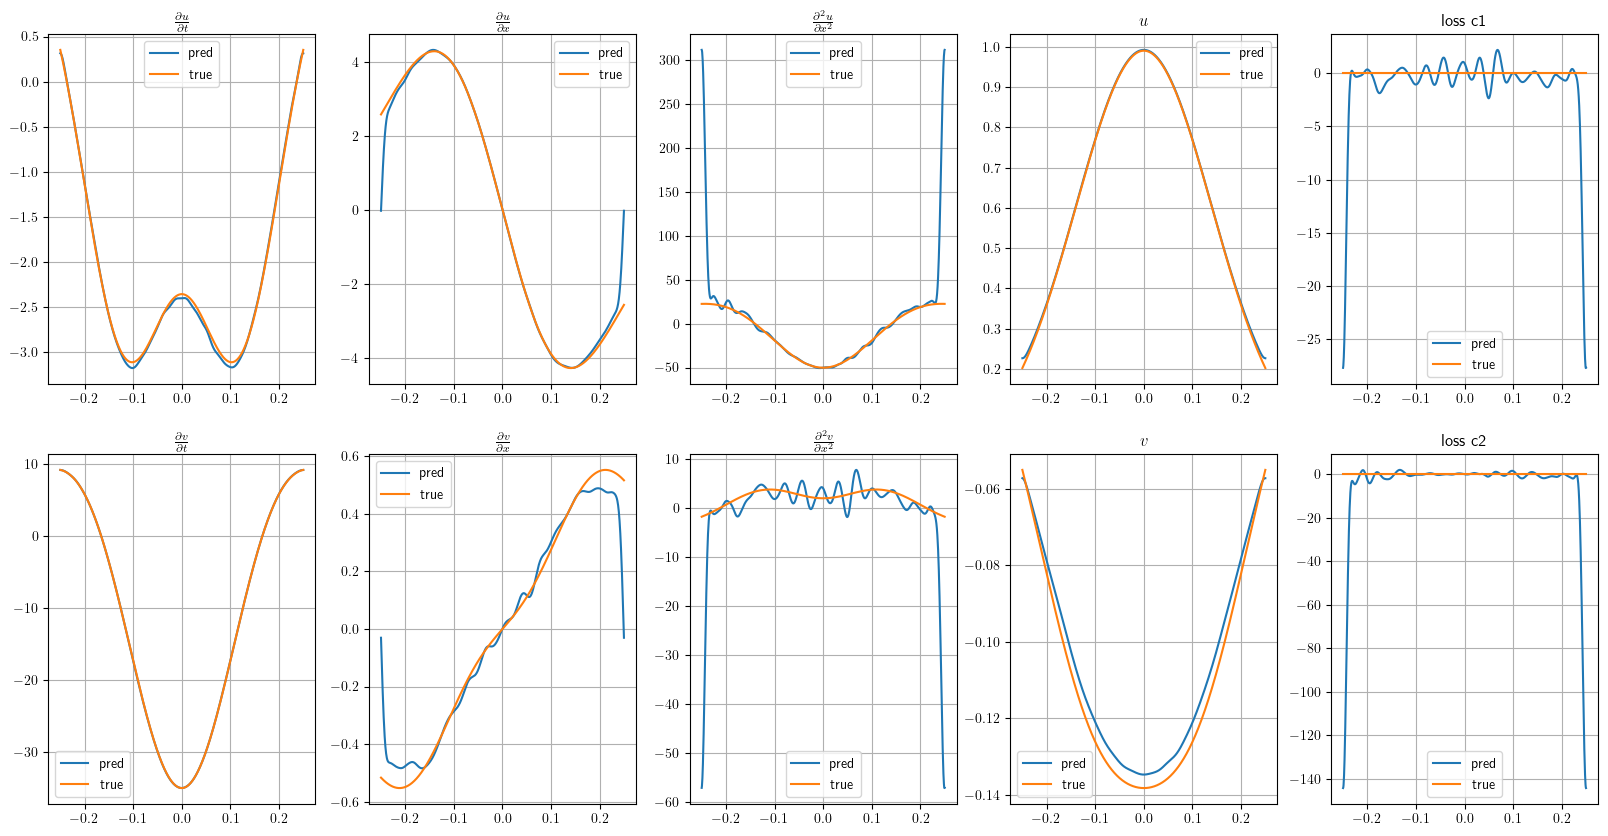

In [9]:
x = jnp.linspace(*domain[:, 0], 1000).reshape((-1, 1))
t = jnp.zeros_like(x)
xt = jnp.hstack([x, t])


# direct_params_ = direct_params
direct_params_ = get_params(opt_state)
duv_dxt = jacobian(direct_params_, xt)
du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
duv_dxxtt = hessian(direct_params_, xt)
du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
uv = model(direct_params_, xt)
u, v = uv[:, 0:1], uv[:, 1:2]
loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["text.usetex"] = True

f, ax = plt.subplots(2, 5, figsize = (20, 10))
i, j = 0, 0
ax[i][j].plot(x, du_dt, label = "pred")
ax[i][j].plot(x, du0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
i = 1
ax[i][j].plot(x, dv_dt, label = "pred")
ax[i][j].plot(x, dv0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dx, label = "pred")
ax[i][j].plot(x, du0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
i = 1
ax[i][j].plot(x, dv_dx, label = "pred")
ax[i][j].plot(x, dv0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dxx, label = "pred")
ax[i][j].plot(x, du0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
i = 1
ax[i][j].plot(x, dv_dxx, label = "pred")
ax[i][j].plot(x, dv0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
i, j = 0, j+1
ax[i][j].plot(x, u, label = "pred")
ax[i][j].plot(x, u0, label = "true")
ax[i][j].set_title(r"$u$")
i = 1
ax[i][j].plot(x, v, label = "pred")
ax[i][j].plot(x, v0, label = "true")
ax[i][j].set_title(r"$v$")
i, j = 0, j+1
ax[i][j].plot(x, loss_c1, label = "pred")
ax[i][j].plot(x, loss_c10, label = "true")
ax[i][j].set_title(r"loss c1")
i = 1
ax[i][j].plot(x, loss_c2, label = "pred")
ax[i][j].plot(x, loss_c20, label = "true")
ax[i][j].set_title(r"loss c2")

for i in range(2):
	for j in range(5):
		ax[i][j].legend()
		ax[i][j].grid()
plt.show()

In [ ]:
get_params(opt_state)

In [10]:
du_dxx

DeviceArray([[ 3.11528259e+02],
             [ 3.10868835e+02],
             [ 3.08693542e+02],
             [ 3.05030060e+02],
             [ 2.99925629e+02],
             [ 2.93447998e+02],
             [ 2.85681885e+02],
             [ 2.76729706e+02],
             [ 2.66707092e+02],
             [ 2.55743301e+02],
             [ 2.43976776e+02],
             [ 2.31554764e+02],
             [ 2.18627243e+02],
             [ 2.05348480e+02],
             [ 1.91870865e+02],
             [ 1.78344452e+02],
             [ 1.64913116e+02],
             [ 1.51712906e+02],
             [ 1.38870056e+02],
             [ 1.26498703e+02],
             [ 1.14699814e+02],
             [ 1.03559494e+02],
             [ 9.31490479e+01],
             [ 8.35230026e+01],
             [ 7.47211533e+01],
             [ 6.67661743e+01],
             [ 5.96664886e+01],
             [ 5.34154358e+01],
             [ 4.79933548e+01],
             [ 4.33684158e+01],
             [ 3.94984131e+01],
        

In [11]:
du0_dxx

DeviceArray([[ 22.434092  ],
             [ 22.444891  ],
             [ 22.454895  ],
             [ 22.464106  ],
             [ 22.472504  ],
             [ 22.48009   ],
             [ 22.486866  ],
             [ 22.492825  ],
             [ 22.49794   ],
             [ 22.502232  ],
             [ 22.505686  ],
             [ 22.5083    ],
             [ 22.510056  ],
             [ 22.510965  ],
             [ 22.511013  ],
             [ 22.510191  ],
             [ 22.508503  ],
             [ 22.505936  ],
             [ 22.5025    ],
             [ 22.498163  ],
             [ 22.49295   ],
             [ 22.486826  ],
             [ 22.479805  ],
             [ 22.471884  ],
             [ 22.463045  ],
             [ 22.453289  ],
             [ 22.442616  ],
             [ 22.431013  ],
             [ 22.418476  ],
             [ 22.405003  ],
             [ 22.390594  ],
             [ 22.37523   ],
             [ 22.35892   ],
             [ 22.341652  ],
             [